In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure
import random
import time

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from data_loader import DataGenerator
from models import VAEmodel, lstmKerasModel
from trainers import vaeTrainer

from utils import process_config, create_dirs, get_args

In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

[]


In [6]:
# load VAE model
config = process_config('NAB_config_scada1.json')#('NAB_config_centralized.json')
# create the experiments dirs
create_dirs([config['result_dir'], config['checkpoint_dir']])
# create tensorflow session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# create your data generator

data = DataGenerator(config)
# create a CNN model
model_vae = VAEmodel(config, "Global")
# create a CNN model
trainer_vae = vaeTrainer(sess, model_vae, data, config)
model_vae.load(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

SCADA
SCADA
SCADA
SCADA



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please

Model loaded.


In [6]:
print(data.__dict__.keys())
for i in data.__dict__.keys():
    if (i not in ['config','train_set_vae','val_set_vae','test_set_vae','train_set_lstm', 'val_set_lstm']):
        print(i ,getattr(data,i))
for i in  ['train_set_vae','val_set_vae','test_set_vae','train_set_lstm', 'val_set_lstm']:
    print(i ,(getattr(data,i)['data']).shape)




dict_keys(['config', 'n_train_vae', 'n_val_vae', 'train_set_vae', 'val_set_vae', 'test_set_vae', 'n_train_lstm', 'n_val_lstm', 'train_set_lstm', 'val_set_lstm'])
n_train_vae 11312
n_val_vae 1257
n_train_lstm 11074
n_val_lstm 1231
train_set_vae (11312, 24, 1)
val_set_vae (1257, 24, 1)
test_set_vae (32, 24, 1)
train_set_lstm (11074, 12, 24, 1)
val_set_lstm (1231, 12, 24, 1)


In [7]:
config['dataset']

'nprs44'

In [7]:
# load LSTM model
lstm_model = lstmKerasModel("Global", config)
lstm_model.produce_embeddings(model_vae, data, sess)
lstm_nn_model = lstm_model.create_lstm_model()
lstm_nn_model.summary()   # Display the model's architecture

# checkpoint path
checkpoint_path = config['checkpoint_dir_lstm'] + "cp_Global.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# load weights if possible
lstm_model.load_model(lstm_nn_model, checkpoint_path)

lstm input: (?, 11, 6)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Finish processing the embeddings of the entire dataset of Global.
lstm input: (?, 11, 6)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 11, 6)]           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 11, 64)            18176     
_________________________________________________________________
lstm_4 (LSTM)                (None, 11, 64)            33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 11, 6)             1704      
Total params: 52,904
Trainable params: 52,904
Non-trainable params: 0
_________________________________________________________________
../experiments/local-results/SCADA1/scada1/batch-32/SCADA1-s

In [7]:
# load normalised time series
save_dir = '../datasets/NAB-known-anomaly/'
# config['dataset'] = 'ecg_8'
dataset = config['dataset']
filename = '{}.npz'.format(dataset)
result = dict(np.load(save_dir+filename, allow_pickle=True))
if dataset == 'machine_temp':
    result['test'] = result['test'][0]
    result['idx_anomaly_test'] = result['idx_anomaly_test'][0]
    result['t_test'] = result['t_test'][0]

# slice into rolling windows and rolling sequences
# slice into rolling windows and rolling sequences
def slice_rolling_windows_and_sequences(config, time_seq):
    n_sample = len(time_seq)
    time_seq = np.reshape(time_seq,(-1,config['n_channel']))
    print("The given sequence has {} samples".format(n_sample))
    n_vae_win = n_sample - config['l_win'] + 1
    rolling_windows = np.zeros((n_vae_win, config['l_win'], config['n_channel']))
    for i in range(n_vae_win):
        rolling_windows[i] = time_seq[i:i + config['l_win']]
        sample_m = np.mean(rolling_windows, axis=1)
        sample_std = np.std(rolling_windows, axis=1)

        n_lstm_seq = n_sample - config['l_seq']*config['l_win']+1
        lstm_seq = np.zeros((n_lstm_seq, config['l_seq'], config['l_win'], config['n_channel']))
    for i in range(n_lstm_seq):
        cur_seq = time_seq[i:i+config['l_seq']*config['l_win']]
        for j in range(config['l_seq']):
            lstm_seq[i,j] = cur_seq[config['l_win']*j:config['l_win']*(j+1)]
    
    return rolling_windows, lstm_seq, sample_m, sample_std

test_windows, test_seq, test_sample_m, test_sample_std = slice_rolling_windows_and_sequences(config, result['test'])
test_windows = np.reshape(test_windows, (-1,config['l_win'],config['n_channel']))
test_seq = np.reshape(test_seq, (-1,config['l_seq'],config['l_win'],config['n_channel']))
print('test_windows ',test_windows.shape)
print('test_seq ',test_seq.shape)

The given sequence has 14786 samples
test_windows  (14763, 24, 1)
test_seq  (14499, 12, 24, 1)


In [68]:
result


{'readings': array([[-0.078, -0.062],
        [-0.081, -0.062],
        [-0.088, -0.062],
        ...,
        [-0.341,  0.055],
        [-0.304,  0.047],
        [-0.287,  0.036]]),
 'idx_anomaly': array([2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301,
        2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312,
        2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323,
        2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334,
        2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345,
        2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356,
        2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367,
        2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378,
        2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389,
        2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400,
        2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 

In [9]:
# Evaluate ELBO and LSTM prediction error on the validation set
# evaluate some anomaly detection metrics
def evaluate_vae_anomaly_metrics_for_a_window(test_win):
    feed_dict = {model_vae.original_signal: np.expand_dims(test_win, 0),
                 model_vae.is_code_input: False,
                 model_vae.code_input: np.zeros((1, config['code_size']))}

    # VAE reconstruction error
    recons_win_vae = np.squeeze(sess.run(model_vae.decoded, feed_dict=feed_dict))
    test_vae_recons_error = np.sum(np.square(recons_win_vae - test_win))

    # VAE latent embedding likelihood
    vae_code_mean, vae_code_std = sess.run([model_vae.code_mean, model_vae.code_std_dev], feed_dict=feed_dict)
    test_vae_kl = 0.5 * (np.sum(np.square(vae_code_mean)) + \
                            np.sum(np.square(vae_code_std)) - \
                            np.sum(np.log(np.square(vae_code_std))) - config['code_size'])

    # VAE ELBO loss
    sigma2 = 0.0005
    input_dims = model_vae.input_dims
    sigma_regularisor = input_dims/2. * np.log(sigma2) + input_dims * np.pi
    test_vae_elbo = test_vae_recons_error/sigma2 + test_vae_kl + sigma_regularisor
    return test_vae_recons_error, test_vae_kl, test_vae_elbo

def evaluate_lstm_anomaly_metric_for_a_seq(test_seq):
    feed_dict = {model_vae.original_signal: test_seq,
                 model_vae.is_code_input: False,
                 model_vae.code_input: np.zeros((1, config['code_size']))}
    vae_embedding = np.squeeze(sess.run(model_vae.code_mean, feed_dict=feed_dict))
    #print(vae_embedding.shape)
    lstm_embedding = np.squeeze(lstm_nn_model.predict(np.expand_dims(vae_embedding[:config['l_seq']-1], 0), batch_size=1))
    lstm_embedding_error = np.sum(np.square(vae_embedding[1:] - lstm_embedding))
    # error_original = vae_embedding[1:] - lstm_embedding
    #print(error_original.shape)
    
    # LSTM prediction error
    feed_dict_lstm = {model_vae.original_signal: np.zeros((config['l_seq'] - 1, config['l_win'], config['n_channel'])),
                      model_vae.is_code_input: True,
                      model_vae.code_input: lstm_embedding}
    recons_win_lstm = np.squeeze(sess.run(model_vae.decoded, feed_dict=feed_dict_lstm))
    lstm_recons_error = np.sum(np.square(recons_win_lstm - np.squeeze(test_seq[1:])))
    error_original = np.abs(recons_win_lstm - np.squeeze(test_seq[1:])).reshape((config['l_seq']-1,-1)) #them dong nay de tinh
    return lstm_recons_error, lstm_embedding_error, error_original

data.val_set_vae['data'] = np.asarray(data.val_set_vae['data'])
print(data.val_set_vae['data'].shape)
data.val_set_lstm['data'] = np.asarray(data.val_set_lstm['data'])
data.train_set_lstm['data'] = np.asarray(data.train_set_lstm['data'])
data.train_set_vae['data'] = np.asarray(data.train_set_vae['data'])
n_val_vae = data.val_set_vae['data'].shape[0]
n_val_lstm = data.val_set_lstm['data'].shape[0]
# print(np.asarray(data.val_set_vae['data']).shape)

val_vae_recons_error = np.zeros(n_val_vae)
val_vae_kl_error = np.zeros(n_val_vae)
val_vae_elbo_loss = np.zeros(n_val_vae)
print(np.reshape(data.val_set_vae['data'][0], (-1, config['l_win'], config['n_channel'])).shape)
for i in range(n_val_vae):
#     val_vae_recons_error[i], val_vae_kl_error[i], val_vae_elbo_loss[i] = evaluate_vae_anomaly_metrics_for_a_window(np.reshape(data.val_set_vae['data'][i], (-1, config['l_win'], config['n_channel'])))
    val_vae_recons_error[i], val_vae_kl_error[i], val_vae_elbo_loss[i] = evaluate_vae_anomaly_metrics_for_a_window(data.val_set_vae['data'][i])

val_lstm_recons_error, val_lstm_embedding_error = np.zeros(n_val_lstm), np.zeros(n_val_lstm)
val_lstm_error_original = np.zeros((n_val_lstm,config['l_seq']-1,config['l_win']*config['n_channel'])) #them de tinh OCSVM
for i in range(n_val_lstm):
    val_lstm_recons_error[i], val_lstm_embedding_error[i], val_lstm_error_original[i] = evaluate_lstm_anomaly_metric_for_a_seq(np.reshape(data.val_set_lstm['data'][i], (-1, config['l_win'], config['n_channel'])))

n_train_lstm = data.train_set_lstm['data'].shape[0]
train_lstm_recons_error, train_lstm_embedding_error = np.zeros(n_train_lstm), np.zeros(n_train_lstm)
train_lstm_error_original = np.zeros((n_train_lstm,config['l_seq']-1,config['l_win']*config['n_channel'])) #them de tinh OCSVM
for i in range(n_train_lstm):
    train_lstm_recons_error[i], train_lstm_embedding_error[i], train_lstm_error_original[i] = evaluate_lstm_anomaly_metric_for_a_seq(np.reshape(data.train_set_lstm['data'][i], (-1, config['l_win'], config['n_channel'])))

(1813, 24, 1)
(1, 24, 1)


In [70]:
config['l_seq']

12

In [10]:
from scipy.stats import norm
def plot_histogram(test_anomaly_metric, n_bins, title, mean=None, std=None, xlim=None, saveplot=False):
    test_anomaly_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    his = plt.hist(test_anomaly_list, bins=n_bins, density=True)
    if mean is None and std is None:
        mean = np.mean(test_anomaly_list)
        std = np.std(test_anomaly_list)
        legend_label = None
    else:
        legend_label = 1
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
    plt.title(title)
    plt.xlabel('anomaly score value')
    plt.ylabel('probability density')
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, np.amax(test_anomaly_list))
    if legend_label is None:
        plt.legend(('Fitted Gaussian', 'histogram'))
    else:
        plt.legend(('normal data distribution','test data distribution (contain anomalies)'))
    if saveplot:
        savefig(config['result_dir']+'reconstruction_error_histogram.pdf')
    else:
        plt.show()
    threshold_25 = np.percentile(test_anomaly_list, 25)
    threshold_75 = np.percentile(test_anomaly_list, 75)
    threshold_1 = np.percentile(test_anomaly_list, 99)
    idx_large_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold_1))
#     print(his[0][-20:])
#     print(his[1][-20:])
    print("25% percentile: {}".format(threshold_25))
    print("75% percentile: {}".format(threshold_75))
#     print("Median: {}".format(np.median(test_anomaly_list)))
#     print("Mean: {}".format(np.mean(test_anomaly_list)))
#     print("Std dev: {}".format(np.std(test_anomaly_list)))
    print("These windows scored the top 1% of anomaly metric ({}): \n{}".format(threshold_1, idx_large_error))
    return mean, std

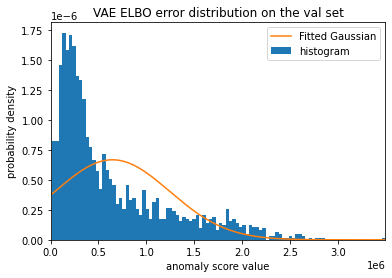

25% percentile: 211141.09428917256
75% percentile: 944312.9623608551
These windows scored the top 1% of anomaly metric (2414313.446597125): 
[1018 1407 1492 1576 1583 1604 1605 1613 1614 1692 1699 1702 1710 1711
 1723 1748 1750 1751 1761]


In [11]:
# Histogram of VAE ELBO loss - validation set
vae_elbo_m, vae_elbo_std = plot_histogram(val_vae_elbo_loss, 100, 
                                          'VAE ELBO error distribution on the val set', 
                                          mean=None, std=None, xlim=None)

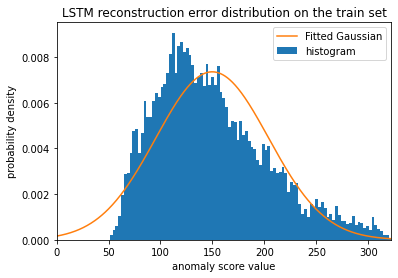

25% percentile: 109.32558705481071
75% percentile: 182.7352424674721
These windows scored the top 1% of anomaly metric (299.491229078309): 
[   84   159   329   389   637   650   781   821   845   901   939  1029
  1073  1336  1354  1760  1846  1858  1895  2028  2300  2547  2550  2581
  2605  2739  2854  2907  2958  3345  3384  3557  3570  3613  3681  3775
  3820  3882  3896  3968  3991  4118  4432  4514  4621  4660  4782  4835
  4859  4913  4918  4948  4954  4998  5811  5840  5846  5848  5850  5874
  6017  6036  6174  6279  6326  6354  6378  6629  6708  6774  6801  6916
  6994  7035  7119  7292  7444  7532  7560  7580  7757  7860  8189  8193
  8491  8545  8598  8689  8793  8870  8974  8987  9011  9087  9090  9107
  9184  9445  9455  9550  9591  9743  9861 10002 10051 10100 10127 10143
 10180 10258 10350 10407 10701 10702 10724 10751 10757 10772 10855 10863
 11035 11077 11116 11139 11276 11330 11401 11475 11677 11712 11728 11835
 11859 12064 12069 12156 12375 12534 12747 12830 13350 13

In [12]:
# Histogram of LSTM reconstruction error - train set 
#  --> to decide the anomaly detection threshold
lstm_recons_m_train, lstm_recons_std_train = plot_histogram(train_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the train set', 
                                              mean=None, std=None, xlim=None)

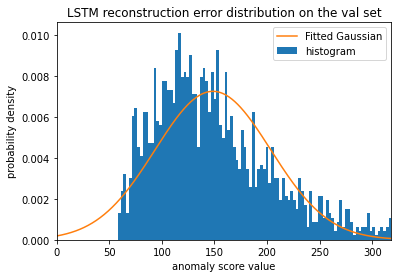

25% percentile: 107.33128384571518
75% percentile: 180.29768888707505
These windows scored the top 1% of anomaly metric (300.33697988154734): 
[ 139  592  664  734  807  882  891 1026 1033 1123 1189 1334 1399 1463
 1552 1562 1642 1783]


In [13]:
# Histogram of LSTM reconstruction error - validation set 
#  --> to decide the anomaly detection threshold
lstm_recons_m_val, lstm_recons_std_val = plot_histogram(val_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the val set', 
                                              mean=None, std=None, xlim=None)

In [14]:
# Evaluate the anomaly metrics on the test windows and sequences
n_test_lstm = test_seq.shape[0]

test_lstm_recons_error, test_lstm_embedding_error = np.zeros(n_test_lstm), np.zeros(n_test_lstm)
test_lstm_error_original = np.zeros((n_test_lstm,config['l_seq']-1,config['l_win']*config['n_channel']))
for i in range(n_test_lstm):
    test_lstm_recons_error[i], test_lstm_embedding_error[i], test_lstm_error_original[i] = evaluate_lstm_anomaly_metric_for_a_seq(test_seq[i])
print("All windows' reconstruction error is computed.")
print("The total number of windows is {}".format(len(test_lstm_recons_error)))

All windows' reconstruction error is computed.
The total number of windows is 14499


25% percentile: 138.26543770497082
75% percentile: 219.36735980811997
These windows scored the top 1% of anomaly metric (350.70640907390737): 
[  59   60   61   62   63   64   65   66   67   68   69   70   71   72
   73   78   79   80   81   82   83   84   85   86   87   88  850  851
  852  853  854  855  856 2746 2747 2748 2749 2750 2751 2752 2753 2754
 2755 2756 2757 2758 2759 2760 2761 2762 2764 2765 2766 2767 2768 2769
 2770 2771 2772 2773 2774 2775 2776 2777 2778 3968 3969 3970 3971 3972
 3973 3974 3975 3976 3977 3978 3979 3980 3981 3982 3983 3984 3985 3986
 3987 3988 3989 3990 3991 3992 3993 3994 3995 3996 3997 3998 3999 4000
 4001 4002 4003 4004 4005 4006 4007 4008 4009 4010 4011 4012 4013 4014
 4015 4016 4017 4018 4019 4020 4021 4022 4023 4024 4025 4026 4027 4028
 4091 4092 4093 4094 4095 4105 4106 4107 4108 4109 4110 4111 4112 4113
 4114 4115 4116 4117 4118]


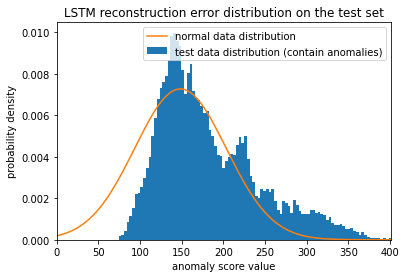

In [15]:
# Histogram of LSTM reconstruction error - test set 
#  --> to detect anomaly now
_, _ = plot_histogram(test_lstm_recons_error, 100,
                      'LSTM reconstruction error distribution on the test set', 
                      mean=lstm_recons_m_val, std=lstm_recons_std_val, xlim=None, saveplot=True)

In [16]:
# Produce the ground truth anomaly indices 
# if result['idx_split'][0] == 0:
#     idx_anomaly_test = result['idx_anomaly_test']
# else:
#     idx_anomaly_test = result['idx_anomaly_test'][0]
idx_anomaly_test = result['idx_anomaly_test']    
anomaly_index_lstm = []
test_labels_lstm = np.zeros(n_test_lstm)
for i in range(len(idx_anomaly_test)):
    idx_start = idx_anomaly_test[i]-(config['l_win']*config['l_seq']-1)
    idx_end = idx_anomaly_test[i]+1
    if idx_start < 0:
        idx_start = 0
    if idx_end > n_test_lstm:
        idx_end = n_test_lstm
    anomaly_index_lstm.append(np.arange(idx_start,idx_end))
    test_labels_lstm[idx_start:idx_end] = 1
    
print(test_labels_lstm.shape)

(14499,)


In [17]:
print(result['idx_anomaly_test'])
print(list(anomaly_index_lstm))
print(test_labels_lstm)

[ 7754  7755  7756 ... 34097 34098 34099]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[0. 0. 0. ... 0. 0. 0.]


(187.0347828454766, 160.80990921933954, 183.21653964078834, 149.83482159480383, 148.50994780391167)
(63.37596568536313, 31.168334048408397, 183.21653964078834, 54.229772505778534, 54.90552972919817)


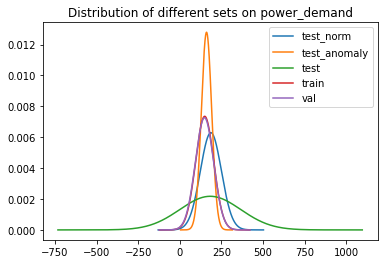

In [18]:
test_normal_idx = np.squeeze(np.argwhere(test_labels_lstm==0))
test_anomaly_idx = np.squeeze(np.argwhere(test_labels_lstm==1))
test_lstm_recons_error_normal = test_lstm_recons_error[test_normal_idx]
test_lstm_recons_error_anomaly = test_lstm_recons_error[test_anomaly_idx]
lstm_recons_m_test_normal = np.mean(test_lstm_recons_error_normal)
lstm_recons_std_test_normal = np.std(test_lstm_recons_error_normal)
lstm_recons_m_test_anomaly = np.mean(test_lstm_recons_error_anomaly)
lstm_recons_std_test_anomaly = np.std(test_lstm_recons_error_anomaly)
lstm_recons_m_test = np.mean(test_lstm_recons_error)
lstm_recons_std_test = np.mean(test_lstm_recons_error)

means = (lstm_recons_m_test_normal, lstm_recons_m_test_anomaly, lstm_recons_m_test, lstm_recons_m_train, lstm_recons_m_val)
stds = (lstm_recons_std_test_normal, lstm_recons_std_test_anomaly, lstm_recons_std_test, lstm_recons_std_train, lstm_recons_std_val)
for mean,std in zip(means,stds):
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    #x_axis = np.arange(-10000,10000)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
plt.legend(('test_norm', 'test_anomaly', 'test', 'train', 'val')) 
#plt.xscale('log')
#plt.yscale('log')
plt.title("Distribution of different sets on " + config['dataset'])
#print(lstm_recons_m_test,lstm_recons_std_test)
#print(lstm_recons_m_val,lstm_recons_std_val)
#print(lstm_recons_m_test_normal,lstm_recons_m_test_normal)
print(means)
print(stds)

In [19]:
def return_anomaly_idx_by_threshold(test_anomaly_metric, threshold):
    test_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    idx_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold))
    
    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)
    
    return list(idx_error)

In [20]:
def augment_detected_idx(idx_detected_anomaly, anomaly_index):
    n_anomaly = len(anomaly_index)
    idx_detected_anomaly_extended = list(idx_detected_anomaly)
    for i in range(n_anomaly):
        #print(idx_detected_anomaly)
        for j in idx_detected_anomaly:
            if j in anomaly_index[i]:
                in_original_detection = set(idx_detected_anomaly_extended)
                currect_anomaly_win = set(anomaly_index[i])
                idx_detected_anomaly_extended = idx_detected_anomaly_extended + list(currect_anomaly_win - in_original_detection)
                #print(j)
                break
                
    return list(np.sort(idx_detected_anomaly_extended))

In [21]:
def count_TP_TN_FP_FN(idx_detected_anomaly, anomaly_index, test_labels):
    n_TP = 0
    n_FP = 0
    n_TN = 0
    n_detection = len(idx_detected_anomaly)
    for i in range(n_detection):
        if test_labels[idx_detected_anomaly[i]] == 1:
            n_TP = n_TP + 1
        else:
            n_FP = n_FP + 1 #both branch the same?

    idx_undetected = list(set(np.arange(len(test_labels)))- set(idx_detected_anomaly))
    n_FN = 0
    for i in idx_undetected:
        if test_labels[i] == 1:
            n_FN = n_FN + 1
        else:
            n_TN = n_TN + 1

    return n_TP, n_TN, n_FP, n_FN

In [22]:
def compute_precision_and_recall(idx_detected_anomaly, anomaly_index, test_labels):
    # compute true positive
    n_TP, n_TN, n_FP, n_FN = count_TP_TN_FP_FN(idx_detected_anomaly, anomaly_index, test_labels)

    accuracy = (n_TP + n_TN) / (n_TP + n_TN + n_FP + n_FN)
    if n_TP + n_FP == 0:
        precision = 1
    else:
        precision = n_TP / (n_TP + n_FP)
    recall = n_TP / (n_TP + n_FN)
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2* (precision * recall)/(precision + recall)

    return accuracy, precision, recall, F1, n_TP, n_TN, n_FP, n_FN

In [23]:
n_threshold = 25
accuracy = np.zeros(n_threshold)
precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)
accuracy_aug = np.zeros(n_threshold)
precision_aug = np.zeros(n_threshold)
recall_aug = np.zeros(n_threshold)
F1_aug = np.zeros(n_threshold)
i = 0
threshold_list = np.linspace(np.amin(test_lstm_recons_error), np.amax(test_lstm_recons_error), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)
for threshold in threshold_list:
    #print(threshold_list[i])
    idx_detection_lstm = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
    accuracy[i], precision[i], recall[i], F1[i], _, _, _, _ = compute_precision_and_recall(idx_detection_lstm, 
                                                                           anomaly_index_lstm, 
                                                                           test_labels_lstm)
    # augment the detection using the ground truth labels
    # a method to discount the factor one anomaly appears in multiple consecutive windows
    # introduced in "Unsupervised anomaly detection via variational auto-encoder for seasonal kpis in web applications"
    idx_detection_lstm_augmented = augment_detected_idx(idx_detection_lstm, anomaly_index_lstm)
    accuracy_aug[i], precision_aug[i], recall_aug[i], F1_aug[i], _, _, _, _ = compute_precision_and_recall(idx_detection_lstm_augmented, 
                                                                                       anomaly_index_lstm, 
                                                                                       test_labels_lstm)
    i = i + 1
    #print(precision, recall, F1)

In [24]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, accuracy is {}, precision is {}, recall is {}".format(accuracy[idx_best_threshold], precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision[1:] * (recall[1:] - recall[:-1]))
print("Average precision is {}".format(average_precision))

print("\nAugmented detection:")
print("Best F1 score is {}".format(np.amax(F1_aug)))
idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
best_thres = np.min(threshold_list[idx_best_threshold])
print("At this threshold, accuracy is {}, precision is {}, recall is {}".format(accuracy_aug[idx_best_threshold], precision_aug[idx_best_threshold], 
                                                                recall_aug[idx_best_threshold]))

average_precision_aug = np.sum(precision_aug[1:] * (recall_aug[1:] - recall_aug[:-1]))
print("Average precision is {}".format(average_precision_aug))

Best F1 score is 0.2575640031031807
Best threshold is 115.2368704905056
At this threshold, accuracy is 0.2079453755431409, precision is 0.1491352848693569, recall is 0.9436286120322123
Average precision is 0.11902003922608322

Augmented detection:
Best F1 score is 0.48992133726647
Best threshold is 210.63181607430107
At this threshold, accuracy is 0.7137733636802538, precision is 0.3307883817427386, recall is 0.9441023211747986
Average precision is 0.26888145326415236


In [25]:
import math
from scipy.stats import norm

def KQp(data,q):
#UNTITLED3 Summary of this function goes here
#   Detailed explanation goes here
    data2 = np.sort(data) #sap xep tang dan
    n = np.shape(data2)[0] #kich thuoc
    p = 1-q #q tu xet, dat bang smth 0.05 0.025 0.01
    h = math.sqrt((p*q)/(n+1));
    KQ=0;
    for i in range(1,n+1):
        a= ((i/n)-p)/h;
        b= (((i-1)/n)-p)/h;
        TP=(norm.cdf(a)-norm.cdf(b))*data2[i-1]; #normcdf thu trong matlab
        KQ=KQ+TP;    
    KQp = KQ;
    return KQp

for i in [0.05,0.025,0.01]:
    print("KQp is:", KQp(test_lstm_recons_error,0.05),"with q =",i)


KQp is: 308.4991113378913 with q = 0.05
KQp is: 308.4991113378913 with q = 0.025
KQp is: 308.4991113378913 with q = 0.01


In [37]:
# Now select a threshold
threshold = best_thres#100.13527662881674
q = 0.25
KQp_thres = KQp(test_lstm_recons_error, q)

print("KQp threshold is {}".format(KQp_thres))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, KQp_thres)
#print(idx_detection)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
#print(anomaly_index_lstm)
#print(idx_detection_augmented)
accuracy, precision, recall, F1, n_TP, n_TN, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using KQE:")
print("Accuracy: {}".format(accuracy))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("TN: {}".format(n_TN))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

print("\nThreshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
accuracy, precision, recall, F1, n_TP, n_TN, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using augmented detection:")
print("Accuracy: {}".format(accuracy))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("TN: {}".format(n_TN))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

KQp threshold is 219.3348153334671

PR evaluation using KQE:
Accuracy: 0.6810814538933719
Precision: 0.22523507544281654
Recall: 0.48792041686404547
F1: 0.3081986834230999
TP: 1030
TN: 8845
FP: 3543
FN: 1081

Threshold is 210.63181607430107

PR evaluation using augmented detection:
Accuracy: 0.7137733636802538
Precision: 0.3307883817427386
Recall: 0.9441023211747986
F1: 0.48992133726647
TP: 1993
TN: 8356
FP: 4032
FN: 118


In [27]:
import numpy as np
for i in range(1,4):
    print(1/i)

1.0
0.5
0.3333333333333333


In [28]:
def slice_detected_indices_into_seq(idx_detection, interval):
    detected_seq = []
    i = 0
    while i < len(idx_detection):
        if i == 0:
            cur_seq = [idx_detection[i]]
            i = i + 1
        else:
            if idx_detection[i] - idx_detection[i-1] > interval:
                detected_seq.append(cur_seq)
                cur_seq = [idx_detection[i]]
            else:
                cur_seq.append(idx_detection[i])
                if i == len(idx_detection) - 1:
                    detected_seq.append(cur_seq)
            i = i + 1
    
    print("Detected {} sequences".format(len(detected_seq)))
    return detected_seq

In [29]:
def plot_detected_anomalies(idx_detection, interval, dataset, result, detection_method, augmented_flag=1, y_scale=5, y_lim=None):
    detected_seq = slice_detected_indices_into_seq(idx_detection, interval=interval)
    #t_test = result['t_test']
    test = result['test']
    t_test = np.array(range(result['test'].shape[0]))
    idx_anomaly_test = result['idx_anomaly_test']
        
    # plot detected sequences
    fig, axs = plt.subplots(1, 1, figsize=(18, 5), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t_test, test)
    for j in range(len(idx_anomaly_test)):
        if j == 0:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--', label='true anomalies')
        else:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')
        
    for i in range(len(detected_seq)):
        for j in detected_seq[i]:
            if j == detected_seq[0][0]:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-', label='detected anomalies')
            else:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-')
    
    for j in range(len(idx_anomaly_test)):
        axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')

    for i in range(len(detected_seq)):
        interval_x = np.asarray([detected_seq[i][0], detected_seq[i][-1]+interval*2])
        interval_y = np.asarray([y_scale,y_scale])
        if i == 0:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y', label='detected anomaly windows')
        else:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
        interval_y = np.asarray([-y_scale,-y_scale])
        axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
    axs.grid(True)
    axs.set_xlim(0, len(t_test))
    if y_lim is None:
        axs.set_ylim(-y_scale, y_scale)
    else:
        axs.set_ylim(-y_scale, y_lim)
#     axs.set_xlabel("timestamp (every {})".format(result['t_unit']))
    axs.set_ylabel("normalised readings")
    axs.set_title("{} dataset test sequence\n(normalised by train mean {:.4f} and std {:.4f})\n Detection method: {}".format(dataset, 
                                                                                        np.mean(result['train_m']), 
                                                                                        np.mean(result['train_std']),
                                                                                        detection_method))
    axs.legend()
    savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))

In [30]:
# plot_detected_anomalies(idx_detection_augmented, 
#                         interval=config['l_win']*config['l_seq']/2, 
#                         dataset=dataset, 
#                         result=result, 
#                         detection_method='lstm reconstruction error',
#                         augmented_flag=1,
#                         y_scale=5,
#                         y_lim=5)

In [31]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

#X_train =
#predicted_train =
#X_test = 
#predicted = 
y_test1 = np.where(test_labels_lstm==1,-1,1) #doi lai label

#OCSVM
#e=X_train - predicted_train
#e = val_lstm_error_original
e = train_lstm_error_original
nsamples, nx, ny = e.shape
d2_e = e.reshape((nsamples,nx*ny))

nu = 0.5 #0.0055
gamma = 'auto' #1.5
from sklearn import svm
clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
clf.fit(d2_e)

#e_t=X_test - predicted
e_t = test_lstm_error_original
nsamples, nx, ny = e_t.shape

d2_e_t = e_t.reshape((nsamples,nx*ny))
y_scores = clf.predict(d2_e_t)

precision = precision_score(y_test1, y_scores, pos_label=-1)
recall    = recall_score(y_test1, y_scores, pos_label=-1)
accuracy = accuracy_score(y_test1, y_scores)
f1 = f1_score(y_test1, y_scores, pos_label=-1)
print ('OSCVM recons abs: ')
print ('Precision : ', precision)
print ('Recall: ', recall)
print ('F1_score: ', f1)
print ('Accuracy : ', accuracy)


OSCVM recons abs: 
Precision :  0.06952505033755774
Recall:  0.2780672666982473
F1_score:  0.1112374455182869
Accuracy :  0.3530588316435616


In [32]:
result['test'].shape


(14786, 1)

In [33]:
a = [1, 1, -1, -1]
b = [1, -1, 1, 1]
precision = precision_score(a,b,pos_label=-1)
recall = recall_score(a,b,pos_label=-1)
print(precision)
print(recall)
f1 = f1_score(a, b, pos_label=-1)
print(f1)

0.0
0.0
0.0


In [34]:
[1,3,4] + [1,7,8]

[1, 3, 4, 1, 7, 8]

In [35]:
y_scores_idx_anomaly = np.squeeze(np.argwhere(y_scores==-1))
idx_augmented = augment_detected_idx(y_scores_idx_anomaly, anomaly_index_lstm)
y_scores[idx_augmented] = -1

precision = precision_score(y_test1, y_scores, pos_label=-1)
recall    = recall_score(y_test1, y_scores, pos_label=-1)
accuracy = accuracy_score(y_test1, y_scores)
f1 = f1_score(y_test1, y_scores, pos_label=-1)
print ('\nOSCVM recons abs augmented: ')
print ('Precision : ', precision)
print ('Recall: ', recall)
print ('F1_score: ', f1)
print ('Accuracy : ', accuracy)


OSCVM recons abs augmented: 
Precision :  0.2117989364904184
Recall:  1.0
F1_score:  0.34956118562675936
Accuracy :  0.45816952893302987
